In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import keras

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import models
#summary
from torchsummary import summary

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu") 

#   Cargar datos

(60000, 28, 28)


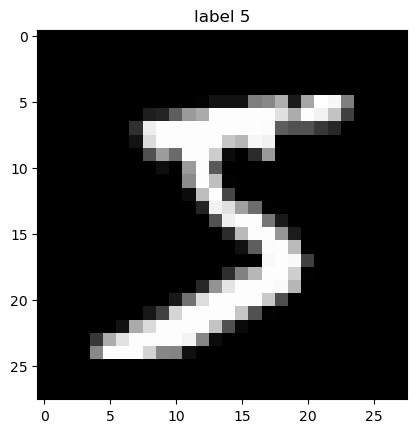

In [3]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
print(x_train.shape)

plt.imshow(x_train[0], cmap='gray')
plt.title("label {}".format(y_train[0]))

x_train = x_train.astype('float32') / np.max(x_train)
x_test = x_test.astype('float32') / np.max(x_test)


#up-scaling to 32
x_train = np.pad(x_train, ((0, 0), (2, 2), (2, 2)), mode='constant')
x_test = np.pad(x_test, ((0, 0), (2, 2), (2, 2)), mode='constant')
x_train = x_train[..., np.newaxis]           # (60000, 32, 32, 1)
x_test  = x_test[..., np.newaxis]            # (10000, 32, 32, 1)

#llevar a device
x_train = torch.tensor(x_train, device=device)
y_train = torch.tensor(y_train, device=device)
x_test = torch.tensor(x_test, device=device)
y_test = torch.tensor(y_test, device=device)


In [4]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(16 * 16 * 16, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)              # (B,16,16,16)
        x = torch.flatten(x, 1)                 # (B, 4096)
        logits = self.fc1(x)                    # (B,10)
        return logits

In [5]:
model = CNN().to("cpu")
summary(model, input_size=(1, 32, 32))
model = model.to(device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             160
            Linear-2                   [-1, 10]          40,970
Total params: 41,130
Trainable params: 41,130
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.13
Params size (MB): 0.16
Estimated Total Size (MB): 0.29
----------------------------------------------------------------


In [6]:
# hiperparametros - dataloader
clases = 10
batch_size = 64
lr = 0.001
validation_split=0.1
N_epochs = 5

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

ds_train = torch.utils.data.TensorDataset(x_train, y_train)
dl_train = torch.utils.data.DataLoader(ds_train, batch_size=batch_size, shuffle=True)

ds_val = torch.utils.data.TensorDataset(x_test, y_test)
dl_val = torch.utils.data.DataLoader(ds_val, batch_size=batch_size, shuffle=False)


In [7]:
train_loss = []
train_acc = []
val_loss = []
val_acc = []

for epoch in range(N_epochs):
    model.train() # 
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in dl_train:
        inputs = inputs.permute(0, 3, 1, 2)  # Cambiar el orden de las dimensiones
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Validación
    model.eval()
    test_loss = 0
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for inputs, labels in dl_val:
            inputs = inputs.permute(0, 3, 1, 2)  # Cambiar el orden de las dimensiones
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            test_correct += (predicted == labels).sum().item()
            test_total += labels.size(0)

    train_loss.append(running_loss / len(dl_train))
    train_acc.append(correct / total)
    val_loss.append(test_loss / len(dl_val))
    val_acc.append(test_correct / test_total)

    print(f"Epoch [{epoch+1}/{N_epochs}], Loss: {train_loss[-1]:.4f}, Accuracy: {train_acc[-1]:.4f}")




Epoch [1/5], Loss: 0.4767, Accuracy: 0.8900
Epoch [2/5], Loss: 0.1533, Accuracy: 0.9585
Epoch [3/5], Loss: 0.1079, Accuracy: 0.9702
Epoch [4/5], Loss: 0.0879, Accuracy: 0.9756
Epoch [5/5], Loss: 0.0756, Accuracy: 0.9788


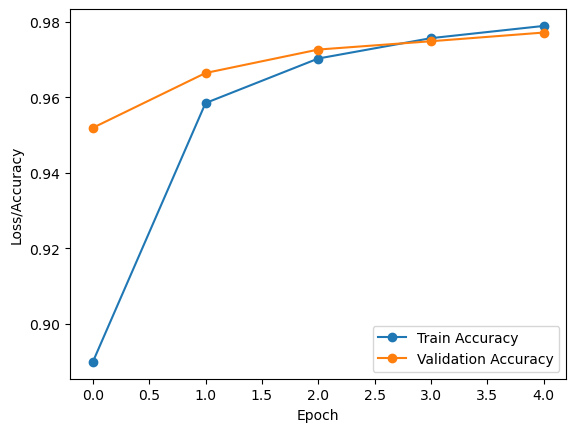

Text(0, 0.5, 'Loss')

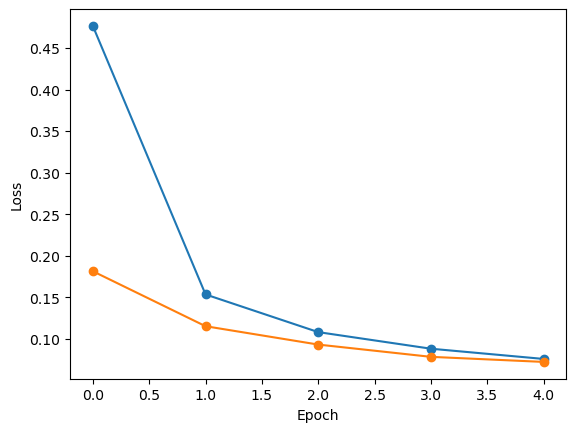

In [9]:
# plt.plot(train_loss, label='Train Loss')
plt.plot(train_acc,'-o', label='Train Accuracy')
# plt.plot(val_loss, label='Validation Loss')
plt.plot(val_acc, '-o', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss/Accuracy')
plt.legend()
plt.show()
#plot loss
plt.plot(train_loss,"-o", label='loss')
plt.plot(val_loss,"-o", label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')